In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
class Easy21:

    def __init__(self, max_length=1000):
        self.max_length = max_length

    def reset(self):
        self.player_first_card_val = np.random.choice(10) + 1
        self.dealer_first_card_val = np.random.choice(10) + 1

        self.player_sum = self.player_first_card_val
        self.dealer_sum = self.dealer_first_card_val

        self.state = [self.dealer_first_card_val, self.player_sum]

        self.player_goes_bust = False
        self.dealer_goes_bust = False

        self.ret = 0
        self.terminal = False
        self.t = 0

        return self.state
    
    def check_term(self,state):
        
        return self.terminal
    
    def step(self, action):
        # action 1: hit   0: stick
        # color: 1: black   -1: red
        r = 0

        ### Player hits
        if action == 1 and self.terminal == False:
            self.player_card_val = np.random.choice(10) + 1
            self.player_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

            self.player_sum += (self.player_card_val * self.player_card_col)
            self.player_goes_bust = self.check_go_bust(self.player_sum)
            
            if self.player_goes_bust == 1:
                    r = -1
                    self.terminal = True
            
            self.t+=1
        
        ### Player sticks
        else:
            ##Dealer hits until sum >=17
            while (not self.terminal) and self.dealer_sum < 17 and self.t <= self.max_length:
                self.dealer_card_val = np.random.choice(10) + 1
                self.dealer_card_col = np.random.choice([-1, 1], p=[1./3., 2./3.])

                self.dealer_sum += (self.dealer_card_val * self.dealer_card_col)
                self.dealer_goes_bust = self.check_go_bust(self.dealer_sum)
            
                ## Dealer goes bust
                if self.dealer_goes_bust == 1:
                    r = 1
                    self.terminal = True
                    break
                    
                self.t+=1
                
            if not self.terminal:
                
                if self.player_sum > self.dealer_sum: 
                    r = 1
                    self.terminal = True
                elif self.player_sum < self.dealer_sum: 
                    r = -1
                    self.terminal = True
                else:  
                    r = 0
                    self.terminal = True

            
        if self.terminal: return 'Terminal', r, self.terminal
        else:
            self.state[1] = self.player_sum
            return self.state, r, self.terminal


    def check_go_bust(self, Sum):
        return bool(Sum > 21 or Sum < 1)

## Monte Carlo Every Visit

In [3]:
## Monte Carlo -- one episode
def monte_carlo_every(Q, Returns, count_state, count_state_action):
    appeared = np.zeros([10, 21, 2], dtype=int)

    actions = []
    rewards = []
    s = env.reset()
    states = [s]
    sumreward = 0
    #state is a [x,y] pair, x: dealers first card, y:player sum
    
    while True:
        action_greedy = Q[s[0]-1, s[1]-1, :].argmax()
        count_state[s[0]-1, s[1]-1] += 1
        epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        actions.append(action)

        s, r, term = env.step(action=action)
        rewards.append(r)

        if term: break
        else: states.append(s)
        
    for t in range(len(states)):
        
        ## ================== change here ================== ##
        
        ####Returns  R(s,a)
        Returns[states[t][0]-1,states[t][1]-1,actions[t-1]] += sum(rewards[t:])
        
        sumreward += Returns[states[t][0]-1,states[t][1]-1,actions[t-1]]
       
        ####count_state_action, N(s,a)

        count_state_action[states[t][0]-1,states[t][1]-1,actions[t-1]] += 1 
        
        ####Q(s,a)
        Q[states[t][0]-1,states[t][1]-1,actions[t-1]] = Returns[states[t][0]-1,states[t][1]-1,actions[t-1]] / count_state_action[states[t][0]-1,states[t][1]-1,actions[t-1]]
      
        ## ================================================= ##
    
   # print("sum: ", sumreward)
    return Q, Returns, count_state, count_state_action

In [92]:
## Monte Carlo
Q_MCe = np.zeros([10, 21, 2]) # Q(s, a)
Returns = np.zeros([10, 21, 2]) # empirical first-visit returns
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

n_episodes = 100000
env = Easy21()

for i_epi in range(n_episodes):
    Q_MCe, Returns, count_state, count_state_action = monte_carlo_every(Q_MCe, Returns, count_state, count_state_action)

V_MCe = Q_MCe.max(axis=2)

In [5]:
## Monte Carlo
Q_MC = np.zeros([10, 21, 2]) # Q(s, a)
Returns = np.zeros([10, 21, 2]) # empirical first-visit returns
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

n_episodes = 40000
env = Easy21()

for i_epi in range(n_episodes):
    Q_MCe, Returns, count_state, count_state_action = monte_carlo_every(Q_MC, Returns, count_state, count_state_action)

V_MCe = Q_MCe.max(axis=2)

In [6]:
def monte_carlo_rewards(Q, Returns, count_state, count_state_action, n_episodes):
    appeared = np.zeros([10, 21, 2], dtype=int)
    mean=0
    sn = 0
    std=0
    mean_list=[] 
    std_list=[] 
    epi_list=[]
    
    actions = []
    rewards = []
    s = env.reset()
    states = [s]
    sumreward = 0
        #state is a [x,y] pair, x: dealers first card, y:player sum

    while True:
            action_greedy = Q[s[0]-1, s[1]-1, :].argmax()
            count_state[s[0]-1, s[1]-1] += 1
            epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])
            action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
            actions.append(action)

            s, r, term = env.step(action=action)
            rewards.append(r)
            sumreward += r
            
            if term: break
            else: states.append(s)

    for t in range(len(states)):

            ## ================== change here ================== ##

            ####Returns  R(s,a)
            Returns[states[t][0]-1,states[t][1]-1,actions[t-1]] += sum(rewards[t:])

            sumreward += Returns[states[t][0]-1,states[t][1]-1,actions[t-1]]

            ####count_state_action, N(s,a)

            count_state_action[states[t][0]-1,states[t][1]-1,actions[t-1]] += 1 

            ####Q(s,a)
            Q[states[t][0]-1,states[t][1]-1,actions[t-1]] = Returns[states[t][0]-1,states[t][1]-1,actions[t-1]] / count_state_action[states[t][0]-1,states[t][1]-1,actions[t-1]]

            ## ================================================= ##
    
    for episode in range(n_episodes):
        rewards_length = len(rewards)
        mean = sumreward / rewards_length
        mean_list.append(mean)
        reward_arr = np.array(rewards)
        std = np.std(reward_arr)
        std_list.append(std)
        epi_list.append(episode)


    return mean_list, std_list,epi_list


In [7]:
## Plot MC rewards against n_episodes
number_episodes = 100000

Q_MC = np.zeros([10, 21, 2]) # Q(s, a)
Returns = np.zeros([10, 21, 2]) # empirical first-visit returns
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

# X: n_episodes
# Y: mean
# Z: standard deviation

Y_MC, Z_MC, X = monte_carlo_rewards(Q_MC, Returns, count_state, count_state_action, number_episodes)


In [ ]:
## Plot MC rewards against n_episodes
Q_MC = np.zeros([10, 21, 2]) # Q(s, a)
Returns = np.zeros([10, 21, 2]) # empirical first-visit returns
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

number_episodes = 100000
X = [] #ep list
Y_MC = [] #mean
Z_MC = [] #std

for i_epi in range(number_episodes):
    Y_MC,Z_MC,X =monte_carlo_rewards(Q_MC, Returns, count_state, count_state_action,i_epi)

#for n_episode in range(n_episodes):
 #   y,z = monte_carlo_rewards(Q_MC, Returns, count_state, count_state_action,i_epi)
  #  Y_MC.append(y)
   # Z_MC.append(z)
    #X.append(n_episode)

In [ ]:
plt.plot(X,Y_MC)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Learning curve (100,000 Episodes)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

In [ ]:
plt.plot(X,Z_MC)
plt.xlabel("Number of episodes")
plt.ylabel("Standard deviation")
plt.title('Learning curve Standard Deviation (100,000 Episodes)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

In [113]:
def get_rewards(Q, count_state, count_state_action):
    appeared = np.zeros([10, 21, 2], dtype=int)

    actions = []
    rewards = []
    s = env.reset()
    states = [s]

    while True:
        action_greedy = Q[s[0]-1, s[1]-1, :].argmax()
        count_state[s[0]-1, s[1]-1] += 1
        epsilon = count_constant / float(count_constant + count_state[s[0]-1, s[1]-1])
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        actions.append(action)

        s, r, term = env.step(action=action)
        rewards.append(r)
        
        if term: break
        else: states.append(s)

    for t in range(len(states)):
        
        ## ================== change here ================== ##
        ####count_state_action, N(s,a)

        count_state_action[states[t][0]-1,states[t][1]-1,actions[t]] += 1 
        
        ####Q(s,a)
        Q[states[t][0]-1,states[t][1]-1,actions[t]] = Returns[states[t][0]-1,states[t][1]-1,actions[t]] / count_state_action[states[t][0]-1,states[t][1]-1,actions[t]]
      
        ## ================================================= ##
    
        return rewards

In [122]:
##where do i change step size
n_episodes = 1000
env = Easy21()
Q = np.zeros([10, 21, 2]) # Q(s, a)
count_state_action = np.zeros([10, 21, 2], dtype=int) # N(s, a)
count_state = np.zeros([10, 21], dtype=int) # N(s)
count_constant = 100

Q_MC =[]
n_epis =[]

for i_epi in range(n_episodes):
        reward= get_rewards(Q, count_state, count_state_action)
        Q_MC[i_epi]=reward
        n_epis[i_epi]=i_epi

## Monte Carlo -- plot
x = Q_MC
y = n_epis

plt.plot(x,y)


plt.xlabel("Number of episodes")
plt.ylabel("Reward value")
plt.title('Monte Carlo Learning curve: Mean')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

IndexError: list assignment index out of range

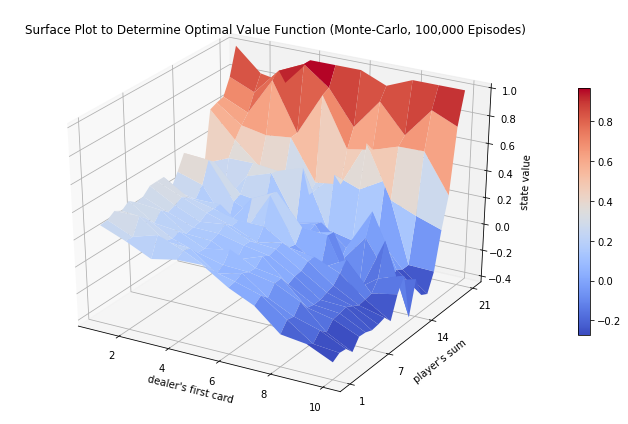

In [60]:
## MC -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_MCf, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Monte-Carlo, 100,000 Episodes)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

-------
# TD: SARSA Implementation

## Define SARSA function

In [72]:
def SARSA(n_episodes, alpha, epsilon):
    
    #epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])
    # Initialize state-action pair to zero
    
    
    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action

    for episode in range(n_episodes):
        Q = np.zeros([10, 21, 2]) 
        #random start
        s = env.reset()
        a = select_action(s)
        #terminal = env.check_term(s)
        
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
                   
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break
            else:
                a_new = select_action(s_new)
                dealer_id_new = s_new[0]-1
                player_id_new = s_new[1]-1
                Q_new = Q[dealer_id_new, player_id_new, a_new]               
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                s = s_new
                a = a_new
        
    return Q

### Number episodes  = 200000, epsilon - 0.05, Varying alpha

In [71]:
n_episodes = 20000
env = Easy21()
epsilon = 0.05

Alpha = np.arange(0,1,0.1)

#initalize MSE-Q-approx
mse_Q_approx = np.zeros(len(Alpha))

n_state_action = 10*21*2

for i_alpha in range(len(Alpha)):
    Q_SARSA = SARSA(n_episodes,i_alpha,epsilon) 
    mse_Q_approx[i_alpha] = (np.sum(np.square(Q_SARSA - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

The best alpha is: 0.0


In [ ]:
## SARSA(lambda) function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()
plt.title('SARSA MSE vs alpha plot (200,000 episodes)')

plt.show()

### Number episodes = 400000, epsilon - 0.05, Varying alpha¶

In [81]:
n_episodes = 100000
env = Easy21()

Alpha = np.arange(0,0.5,0.1)
epsilon = 0.05
#initalize MSE-Q-approx
mse_Q_approx = np.zeros(len(Alpha))

n_state_action = 10*21*2

for i_alpha in range(len(Alpha)):
    Q_SARSA = SARSA(n_episodes,i_alpha, epsilon) 
    mse_Q_approx[i_alpha] = (np.sum(np.square(Q_SARSA - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

KeyboardInterrupt: 

In [ ]:
## SARSA(lambda) function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()
plt.title('SARSA MSE vs lambda plot (100,000 episodes)')

plt.show()

### Number episodes = 200000, Varying epsilon, alpha = 0.05

In [84]:
n_episodes = 20000
env = Easy21()

alpha = 0.05
Epsilon = np.arange(0,0.8,0.1)

#initalize MSE-Q-approx
mse_Q_approx = np.zeros(len(Epsilon))

n_state_action = 10*21*2

for i_eps in range(len(Epsilon)):
    Q_SARSA_eps = SARSA(n_episodes,alpha, i_eps) 
    mse_Q_approx[i_eps] = (np.sum(np.square(Q_SARSA_eps - Q_MCe))) / n_state_action
    

ValueError: probabilities are not non-negative

## Surface plot

In [441]:
n_episodes = 200000
#for i_epi in range(n_episodes):
Q_Sarsa_surf = SARSA(n_episodes, 0.05,0.05)
V_Sarsa = Q_Sarsa_surf.max(axis=2)

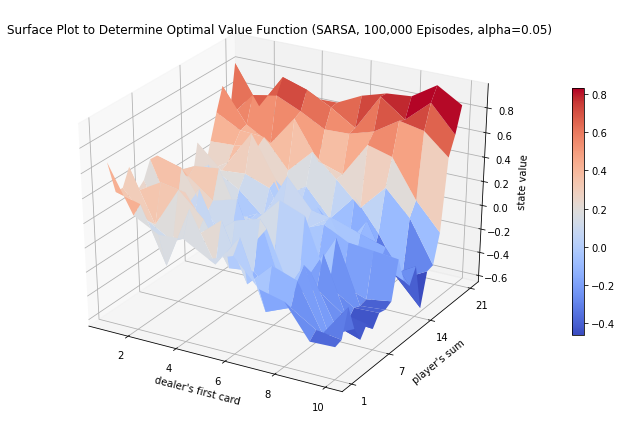

In [442]:
## Sarsa -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Sarsa, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (SARSA, 100,000 Episodes, alpha=0.05)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

## Get mean and standard deviation curves

In [73]:
def SARSA_rewards(n_episodes, alpha):
    appeared = np.zeros([10, 21, 2], dtype=int)
     
    mean_list = []
    sn = 0
    std_list= []
    epi_list =[]
    
    rewards = []
    sumreward = 0    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])

    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action
    
    for episode in range(n_episodes):
         # Initialize state-action pair to zero
        Q = np.zeros([10, 21, 2])

        #random start
        s = env.reset()
        a = select_action(s)
        
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
            rewards.append(r)       
            sumreward+=r
            
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break       
            
            a_new = select_action(s_new)
            dealer_id_new = s_new[0]-1
            player_id_new = s_new[1]-1
            Q_new = Q[dealer_id_new, player_id_new, a_new]               
            Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
            s = s_new
            a = a_new
        
        
        
        rewards_length = len(rewards)
        mean = sumreward / rewards_length
        mean_list.append(mean)
        reward_arr = np.array(rewards)
        std = np.std(reward_arr)
        std_list.append(std)
        epi_list.append(episode)
        
    return mean_list, std_list, epi_list


In [87]:
## Plot SARSA rewards against n_episodes
number_episodes = 100000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y_SARSA, Z_SARSA, X = SARSA_rewards(number_episodes, 0.3)

KeyboardInterrupt: 

In [ ]:
plt.plot(X,Y_SARSA)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Learning curve: Mean (10,000 Episodes)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

In [ ]:
plt.plot(X,Z_SARSA)
plt.xlabel("Number of episodes")
plt.ylabel("Standard deviation")
plt.title('Learning curve: Standard Deviation(10,000 Episodes)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

-----
# Q-learning

In [443]:
def Q_learn(n_episodes, alpha):
    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])

    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action
    Q = np.zeros([10, 21, 2]) 
    
    for episode in range(n_episodes):        

        #random start
        s = env.reset()
        a = select_action(s)
        #terminal = env.check_term(s)
        
        #t =0
        # while t < max_steps:
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
                   
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break
            
            else:
                
                dealer_id_new = s_new[0]-1
                player_id_new = s_new[1]-1
                
                a_new = np.argmax(Q[dealer_id_new,player_id_new,:])
                
                Q_new = Q[dealer_id_new, player_id_new, :].argmax()           
                
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                s = s_new
                a = a_new
        
    return Q

In [444]:
n_episodes = 40000
env = Easy21()

Alpha = np.arange(0,1,0.1)

#initalize MSE-Q-approx
mse_Q_approx_ql = np.zeros(len(Alpha))

n_state_action = 10*21*2

for i_alpha in range(len(Alpha)):
    Q_Qlearn = Q_learn(n_episodes,i_alpha) 
    mse_Q_approx_ql[i_alpha] = (np.sum(np.square(Q_Qlearn - Q_MCe))) / n_state_action

print("The best alpha is:", Alpha[mse_Q_approx.argmin()])
                        

KeyboardInterrupt: 

In [ ]:
# Qlearn function approximation -- MSE vs. lambda plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(Alpha, mse_Q_approx_ql, linewidth=2)

ax.set_xlabel("Alpha value")
ax.set_ylabel("mse of Q")
fig.tight_layout()
plt.title('Q-learning: MSE vs alpha plot (40,000 episodes)')

plt.show()

In [424]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Qlearn_surf = Q_learn(n_episodes, 0.1)
V_Qlearn = Q_Qlearn_surf.max(axis=2)

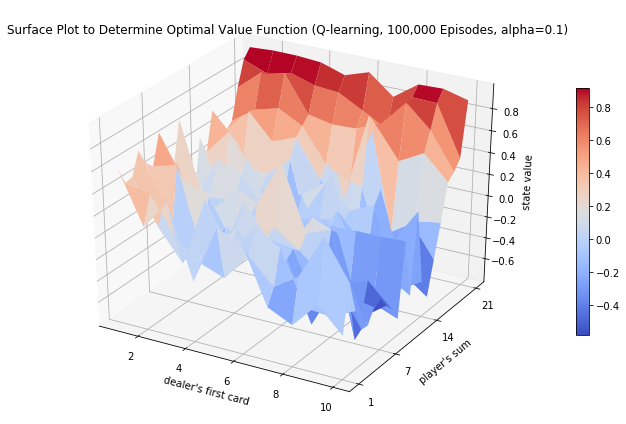

In [426]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Qlearn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Q-learning, 100,000 Episodes, alpha=0.1)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [427]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Qlearn_surf = Q_learn(n_episodes, 0.3)
V_Qlearn = Q_Qlearn_surf.max(axis=2)

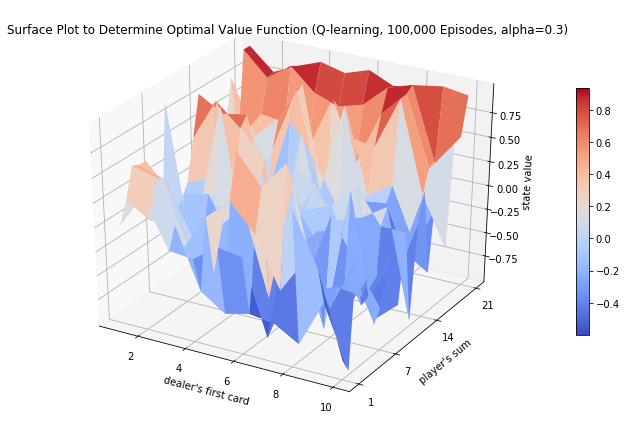

In [428]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Qlearn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Q-learning, 100,000 Episodes, alpha=0.3)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

In [439]:
n_episodes = 100000
#for i_epi in range(n_episodes):
Q_Qlearn_surf = Q_learn(n_episodes, 0.05)
V_Qlearn = Q_Qlearn_surf.max(axis=2)

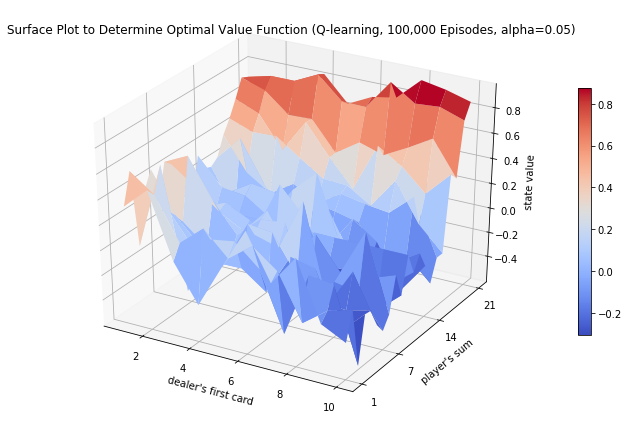

In [440]:
## Q-learning -- plot
s1 = np.arange(10)+1
s2 = np.arange(21)+1
ss1, ss2 = np.meshgrid(s1, s2, indexing='ij')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(ss1, ss2, V_Qlearn, cmap=cm.coolwarm)

ax.set_xlabel("dealer's first card")
ax.set_ylabel("player's sum")
ax.set_zlabel("state value")
plt.yticks([1, 5, 10])
plt.yticks([1, 7, 14, 21])
plt.title('Surface Plot to Determine Optimal Value Function (Q-learning, 100,000 Episodes, alpha=0.05)')
fig.colorbar(surf, shrink=0.6)
fig.tight_layout()

plt.show()

## Learning curves

In [76]:
def QLearn_rewards(n_episodes, alpha):
    appeared = np.zeros([10, 21, 2], dtype=int)
     
    mean_list = []
    sn = 0
    std_list= []
    epi_list =[]
    
    rewards = []
    sumreward = 0    
    epsilon = 0.05
    
    #Initialise the state value function to zero
    V = np.zeros([10,21])

    def select_action(state):
        
        action_greedy = Q[state[0]-1,state[1]-1,:].argmax()
        action = np.random.choice([action_greedy, 1 - action_greedy], p=[1. - epsilon/2., epsilon/2.])
        
        return action
    
    for episode in range(n_episodes):
         # Initialize state-action pair to zero
        Q = np.zeros([10, 21, 2])

        #random start
        s = env.reset()
        a = select_action(s)
        
        while True:         
            #excute action a, observe s_new and r
            s_new,r,done = env.step(a)            
            dealer_id = s[0]-1
            player_id = s[1]-1
            rewards.append(r)       
            sumreward+=r
            
            ## if terminal state is reached
            if done:
                Q_new =0
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                break       
            
            

         
            else:
                
                dealer_id_new = s_new[0]-1
                player_id_new = s_new[1]-1
                
                a_new = Q[dealer_id_new,player_id_new,:].argmax()
                
                Q_new = Q[dealer_id_new, player_id_new, a_new]          
                
                Q[dealer_id,player_id,a] += alpha*(r + Q_new - Q[dealer_id,player_id,a])
                s = s_new
                a = a_new
            
        rewards_length = len(rewards)
        mean = sumreward / rewards_length
        mean_list.append(mean)
        reward_arr = np.array(rewards)
        std = np.std(reward_arr)
        std_list.append(std)
        epi_list.append(episode)
        
    return mean_list, std_list, epi_list


### 10,000 episodes, alpha=0.3

In [78]:
## Plot Qlearning rewards against n_episodes

number_episodes = 100000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y_QL, Z_QL, X = QLearn_rewards(number_episodes, 0.3)

KeyboardInterrupt: 

In [ ]:
plt.plot(X,Y_QL)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Q-Learning Learning Curve: Mean (100,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

In [ ]:
plt.plot(X,Z_QL)
plt.xlabel("Number of episodes")
plt.ylabel("Standard Deviation")
plt.title('Q-Learning Learning Curve: Standard Deviation (10,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

### 100,000 episodes, alpha=0.3

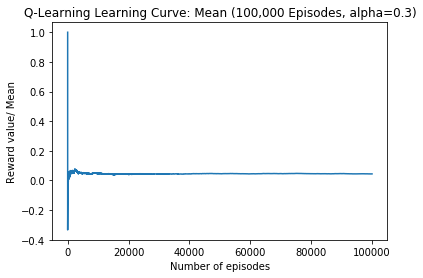

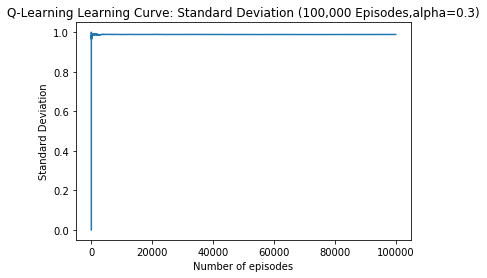

In [451]:
## Plot Qlearning rewards against n_episodes

number_episodes = 100000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y, Z, X = QLearn_rewards(number_episodes, 0.3)

plt.plot(X,Y)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Q-Learning Learning Curve: Mean (100,000 Episodes, alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

plt.plot(X,Z)
plt.xlabel("Number of episodes")
plt.ylabel("Standard Deviation")
plt.title('Q-Learning Learning Curve: Standard Deviation (100,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

### 100,000 episodes, alpha=0.05

In [ ]:

number_episodes = 100000

# X: n_episodes
# Y: mean
# Z: standard deviation

Y, Z, X = QLearn_rewards(number_episodes, 0.3)

plt.plot(X,Y)
plt.xlabel("Number of episodes")
plt.ylabel("Reward value/ Mean")
plt.title('Q-Learning Learning Curve: Mean (100,000 Episodes, alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

plt.plot(X,Z)
plt.xlabel("Number of episodes")
plt.ylabel("Standard Deviation")
plt.title('Q-Learning Learning Curve: Standard Deviation (100,000 Episodes,alpha=0.3)')
#plt.yticks([1, 5, 10])
#plt.yticks([1, 7, 14, 21])


plt.show()

In [ ]:
## Plot the different algorithms

In [85]:
import matplotlib.pyplot as plt

NameError: name 'Y_SARSA' is not defined

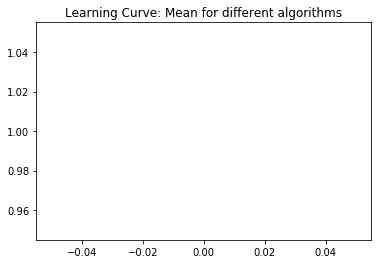

In [86]:

plt.title("Learning Curve: Mean for different algorithms")
plt.plot(X, Y_MC, 'r', label = 'Monte-Carlo') # plotting t, a separately 
plt.plot(X, Y_SARSA, 'b', label = 'SARSA') # plotting t, b separately 
plt.plot(X, Y_QL, 'g', label = 'Q-learning') # plotting t, c separately 
plt.show()

In [ ]:
plt.title("Learning Curve: Standard deviation for different algorithms")
plt.plot(X, Z_MC, 'r') # plotting t, a separately 
plt.plot(X, Z_SARSA, 'b') # plotting t, b separately 
plt.plot(X, Z_QL, 'g') # plotting t, c separately 
plt.show()